In [1]:
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
from loguru import logger
import pdb

from valleyfloor.process_topography import process_topography
from valleyfloor.delineate_reaches import delineate_reaches
from valleyfloor.utils import setup_wbt

logger.enable("valleyfloor")

In [2]:
wbt = setup_wbt("~/opt/WBT/", "../working_dir")

dem = rxr.open_rasterio("../data/input/dem.tif", masked=True).squeeze()
flowlines = gpd.read_file("../data/input/flowlines.shp")

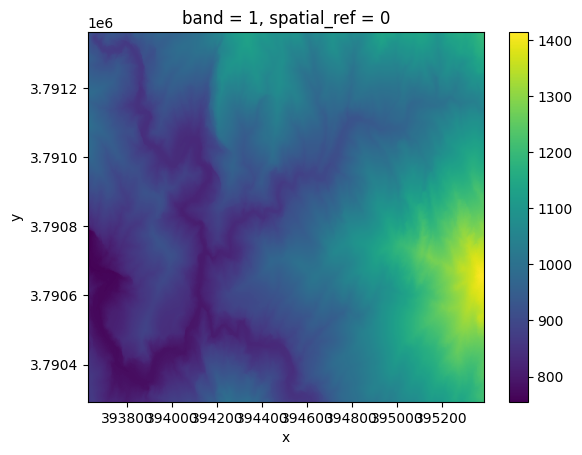

In [3]:
dem.plot()

<Axes: >

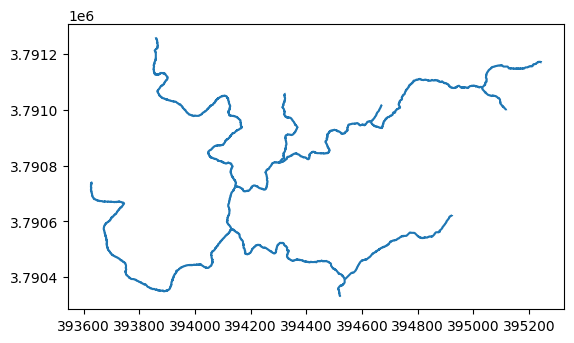

In [4]:
flowlines.plot()

In [9]:
dataset, aligned_flowlines = process_topography(dem, flowlines, wbt)

2024-10-07 22:11:49.434 | INFO     | valleyfloor.process_topography:process_topography:36 - process topography
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/slopes-3UmQq1a1-py3.10/lib/python3.10/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [43]:
from valleyfloor.flow.watershed import watershed_points
from valleyfloor.flow.hillslope import label_drainage_sides

In [ ]:
# skip the segmenting into reaches
# still need to watershed and hillslope, maybe need to update the reach segmentation code to be able to handle 1m dem, e.g. no hardcoded cell counts
# different min length of a reach
# then get profiles
# could use wbt to get watershed for now
# hillslopes we can get